# Partial Dependence Plot Membership Inference Experiments

In [1]:
import pandas as pd
from sklearnex import patch_sklearn
patch_sklearn()
import sklearn.ensemble as es
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
from sklearn.inspection import partial_dependence
from sklearn.inspection import PartialDependenceDisplay
import numpy as np
import logging

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
threads = 15

logging.basicConfig()

logger = logging.getLogger('xai-privacy')

In [3]:
from experiment_setup import run_all_experiments
from experiment_setup import get_heart_disease_dataset
from experiment_setup import get_census_dataset

In [4]:
DATASET_HALF = False

data_heart_dict, data_heart_num_dict, data_heart_cat_dict = get_heart_disease_dataset(halve_dataset=DATASET_HALF)
data_census_dict, data_census_num_dict, data_census_cat_dict = get_census_dataset(halve_dataset=DATASET_HALF)

data_heart = data_heart_dict['dataset']
outcome_name_heart = data_heart_dict['outcome']
numeric_features_heart = data_heart_dict['num']

Feature Age: removed 0 rows for missing values.
Feature RestingBP: removed 59 rows for missing values.
Feature Cholesterol: removed 27 rows for missing values.
Feature FastingBS: add unknown category 2.0
Feature RestingECG: add unknown category 3.0
Feature MaxHR: removed 0 rows for missing values.
Feature Oldpeak: removed 7 rows for missing values.
Feature ST_Slope: add unknown category 4.0
Feature CA: add unknown category 4.0
Feature Thal: add unknown category 8.0
Dropped 271 of 1097
Dropped 273 of 1097
Dropped 277 of 1097
Dropped: 2399 of 32561
census: Dropped 3848 of 30162
num: Dropped 19859 of 30162
cat: Dropped 12136 of 30162


This notebook will go through the experiment for membership inference with the partial dependence plot (PDP). Membership inference means an attacker with access to the explanation can tell for a sample whether it was included in the training data or not.

The idea for PDP membership inference is as follows: The PDP shows the partial dependence for each feature value that occurs in the training data. Check for each feature value of the given sample if there exists a datapoint at that x-value in the PDP for that feature. If at least one feature value does not appear in the respective PDP, then the sample cannot be part of the training data. Otherwise, the sample may be part of the training data.

First, we implement the `train_explainer` and `membership_inference_attack_no_model_access` functions:

In [5]:
# Attack code must be imported so that multiprocessing pool works. Check out pdp_attack.py for the implementation of the attack.
from pdp_attack import PDPMembershipInference

# Executing Membership Inference

Before running the experiment, we we will have a short look at the visual explanation of a PDP. The underlying data of these graphs will be our attack vector for membership inference.

The line represents the average prediction for all possible feature values of the feature 'age'.

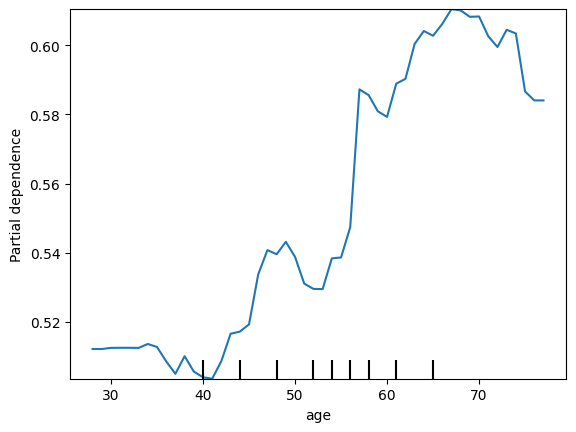

In [6]:
# Train a random forest model on training data.
features = data_heart.drop(outcome_name_heart, axis=1)
labels = data_heart[outcome_name_heart]

model = es.RandomForestClassifier(random_state=0)
model = model.fit(features, labels)

display = PartialDependenceDisplay.from_estimator(estimator=model, X=features, features=[0], feature_names=['age'],
       grid_resolution=len(data_heart), random_state=0)

As a proof of concept for our privacy attack, we run the experiment with a very small amount of repetitions with logging to show that the membership inference function works in principle.

In [7]:
logger.setLevel(logging.DEBUG)

EXP = PDPMembershipInference(data_heart, numeric_features_heart, outcome_name_heart, random_state=5)
EXP.membership_inference_experiment(num_queries=10, model=DecisionTreeClassifier(random_state=0), model_access=False, threads=1)

logger.setLevel(logging.INFO)

DEBUG:xai-privacy:Numeric Features: ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
DEBUG:xai-privacy:Categorical Features: ['CA', 'ChestPainType', 'ExerciseAngina', 'FastingBS', 'RestingECG', 'ST_Slope', 'Sex', 'Thal']
DEBUG:xai-privacy:Removed 9 test samples due to unknown category.
DEBUG:xai-privacy:[[4.70e+01 1.00e+00 4.00e+00 1.12e+02 2.04e+02 0.00e+00 0.00e+00 1.43e+02
  0.00e+00 1.00e-01 1.00e+00 0.00e+00 3.00e+00 0.00e+00]] taken from training data
DEBUG:xai-privacy:[[ 56.    1.    4.  130.  203.    1.    0.   98.    0.    1.5   2.    4.
    7.    1. ]] taken from test data
DEBUG:xai-privacy:[[ 58.   0.   4. 100. 248.   0.   2. 122.   0.   1.   2.   0.   3.   0.]] taken from training data
DEBUG:xai-privacy:[[ 63.   0.   4. 150. 407.   0.   2. 154.   0.   4.   2.   3.   7.   1.]] taken from test data
DEBUG:xai-privacy:[[ 57.    1.    3.  105.    0.    2.    0.  148.    0.    0.3   2.    4.
    8.    1. ]] taken from training data
DEBUG:xai-privacy:[[ 33.   0.   4. 100. 2

Total time: 1.95s (training model: 0.01s, training explainer: 1.82s, experiment: 0.12s)
Accuracy: 0.8, precision: 0.7142857142857143, recall: 1.0


The proof of concept should show that the membership inference function predicts membership accurately in some cases. A false negative should not appear (recall is 100%). However, only some test samples are actually detected as not being part of the training data. You can change the random state to try out a few different runs with different chosen samples.

Now we begin executing the actual experiment. We begin by defining the table that will hold the results for all our different experiment variations. Then we execute all variations of the experiment for this dataset. We vary the model between a decision tree, a random forest and a neural network. Each model uses the default configuration of scikit-learn.

In [8]:
dataset_dicts = [data_heart_dict, data_heart_num_dict, data_heart_cat_dict, data_census_dict, data_census_num_dict, data_census_cat_dict]

dt_dict = {'name': 'decision tree', 'model': DecisionTreeClassifier}
rf_dict = {'name': 'random forest', 'model': es.RandomForestClassifier}
nn_dict = {'name': 'neural network', 'model': MLPClassifier}

model_dicts = [dt_dict, rf_dict, nn_dict]

In [9]:
# This will run the experiment for each dataset and model combination
results = run_all_experiments(PDPMembershipInference, dataset_dicts, model_dicts, random_state=0, num_queries=None, model_access=False, threads=threads, repeat=10)

dataset: heart, model: decision tree (repetition 0)
Total time: 4.65s (training model: 0.01s, training explainer: 1.77s, experiment: 2.86s)
Accuracy: 0.6313868613138686, precision: 0.5768156424581006, recall: 1.0
dataset: heart, model: decision tree (repetition 1)
Total time: 4.89s (training model: 0.00s, training explainer: 1.94s, experiment: 2.96s)
Accuracy: 0.6185819070904646, precision: 0.5696551724137932, recall: 1.0
dataset: heart, model: decision tree (repetition 2)
Total time: 4.55s (training model: 0.02s, training explainer: 1.69s, experiment: 2.85s)
Accuracy: 0.6409313725490197, precision: 0.5849858356940509, recall: 1.0
dataset: heart, model: decision tree (repetition 3)
Total time: 4.62s (training model: 0.02s, training explainer: 1.72s, experiment: 2.89s)
Accuracy: 0.6703296703296703, precision: 0.6046852122986823, recall: 1.0
dataset: heart, model: decision tree (repetition 4)
Total time: 4.64s (training model: 0.01s, training explainer: 1.73s, experiment: 2.91s)
Accuracy

c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total time: 6.57s (training model: 1.00s, training explainer: 2.68s, experiment: 2.88s)
Accuracy: 0.6332518337408313, precision: 0.5792426367461431, recall: 1.0
dataset: heart, model: neural network (repetition 1)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total time: 6.56s (training model: 1.02s, training explainer: 2.67s, experiment: 2.87s)
Accuracy: 0.620563035495716, precision: 0.5712309820193637, recall: 1.0
dataset: heart, model: neural network (repetition 2)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total time: 6.57s (training model: 0.99s, training explainer: 2.71s, experiment: 2.86s)
Accuracy: 0.6176470588235294, precision: 0.5696551724137932, recall: 1.0
dataset: heart, model: neural network (repetition 3)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total time: 6.42s (training model: 0.99s, training explainer: 2.58s, experiment: 2.84s)
Accuracy: 0.6552984165651644, precision: 0.5933908045977011, recall: 1.0
dataset: heart, model: neural network (repetition 4)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total time: 6.51s (training model: 1.01s, training explainer: 2.65s, experiment: 2.86s)
Accuracy: 0.6405867970660146, precision: 0.5841584158415841, recall: 1.0
dataset: heart, model: neural network (repetition 5)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total time: 6.53s (training model: 1.03s, training explainer: 2.64s, experiment: 2.87s)
Accuracy: 0.6373626373626373, precision: 0.5816901408450704, recall: 1.0
dataset: heart, model: neural network (repetition 6)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total time: 6.61s (training model: 0.99s, training explainer: 2.75s, experiment: 2.87s)
Accuracy: 0.6482843137254902, precision: 0.59, recall: 1.0
dataset: heart, model: neural network (repetition 7)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total time: 6.60s (training model: 1.02s, training explainer: 2.63s, experiment: 2.95s)
Accuracy: 0.6413708690330477, precision: 0.5849858356940509, recall: 1.0
dataset: heart, model: neural network (repetition 8)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total time: 6.53s (training model: 1.03s, training explainer: 2.64s, experiment: 2.85s)
Accuracy: 0.6279357231149567, precision: 0.5784313725490197, recall: 1.0
dataset: heart, model: neural network (repetition 9)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total time: 6.55s (training model: 1.01s, training explainer: 2.66s, experiment: 2.88s)
Accuracy: 0.6329268292682927, precision: 0.5784313725490197, recall: 1.0
dataset: heart numeric, model: decision tree (repetition 0)
Total time: 3.56s (training model: 0.01s, training explainer: 0.71s, experiment: 2.85s)
Accuracy: 0.6552567237163814, precision: 0.5936599423631124, recall: 1.0
dataset: heart numeric, model: decision tree (repetition 1)
Total time: 3.61s (training model: 0.00s, training explainer: 0.74s, experiment: 2.87s)
Accuracy: 0.6349206349206349, precision: 0.5794655414908579, recall: 1.0
dataset: heart numeric, model: decision tree (repetition 2)
Total time: 3.62s (training model: 0.00s, training explainer: 0.73s, experiment: 2.89s)
Accuracy: 0.6127450980392157, precision: 0.5659340659340659, recall: 1.0
dataset: heart numeric, model: decision tree (repetition 3)
Total time: 3.63s (training model: 0.00s, training explainer: 0.76s, experiment: 2.87s)
Accuracy: 0.6526576019777504

c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total time: 4.58s (training model: 0.58s, training explainer: 1.16s, experiment: 2.85s)
Accuracy: 0.6515892420537898, precision: 0.5911047345767575, recall: 1.0
dataset: heart numeric, model: neural network (repetition 1)
Total time: 4.55s (training model: 0.58s, training explainer: 1.14s, experiment: 2.83s)
Accuracy: 0.6297662976629766, precision: 0.5778401122019635, recall: 1.0
dataset: heart numeric, model: neural network (repetition 2)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total time: 4.58s (training model: 0.63s, training explainer: 1.13s, experiment: 2.83s)
Accuracy: 0.6544117647058824, precision: 0.5936599423631124, recall: 1.0
dataset: heart numeric, model: neural network (repetition 3)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total time: 4.65s (training model: 0.60s, training explainer: 1.22s, experiment: 2.83s)
Accuracy: 0.6075794621026895, precision: 0.5620736698499318, recall: 1.0
dataset: heart numeric, model: neural network (repetition 4)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total time: 4.72s (training model: 0.63s, training explainer: 1.24s, experiment: 2.86s)
Accuracy: 0.630407911001236, precision: 0.5794655414908579, recall: 1.0
dataset: heart numeric, model: neural network (repetition 5)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total time: 4.65s (training model: 0.63s, training explainer: 1.19s, experiment: 2.83s)
Accuracy: 0.6358099878197321, precision: 0.5794655414908579, recall: 1.0
dataset: heart numeric, model: neural network (repetition 6)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total time: 4.58s (training model: 0.61s, training explainer: 1.14s, experiment: 2.83s)
Accuracy: 0.6621454993834772, precision: 0.6005830903790087, recall: 1.0
dataset: heart numeric, model: neural network (repetition 7)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total time: 4.62s (training model: 0.63s, training explainer: 1.16s, experiment: 2.83s)
Accuracy: 0.6455542021924482, precision: 0.5860597439544808, recall: 1.0
dataset: heart numeric, model: neural network (repetition 8)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total time: 4.63s (training model: 0.63s, training explainer: 1.18s, experiment: 2.83s)
Accuracy: 0.6407407407407407, precision: 0.5860597439544808, recall: 1.0
dataset: heart numeric, model: neural network (repetition 9)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total time: 4.62s (training model: 0.62s, training explainer: 1.17s, experiment: 2.83s)
Accuracy: 0.6326781326781327, precision: 0.5794655414908579, recall: 1.0
dataset: heart categorical, model: decision tree (repetition 0)
Total time: 3.21s (training model: 0.02s, training explainer: 0.28s, experiment: 2.91s)
Accuracy: 0.5049261083743842, precision: 0.5049261083743842, recall: 1.0
dataset: heart categorical, model: decision tree (repetition 1)
Total time: 3.21s (training model: 0.02s, training explainer: 0.31s, experiment: 2.88s)
Accuracy: 0.5012224938875306, precision: 0.5012224938875306, recall: 1.0
dataset: heart categorical, model: decision tree (repetition 2)
Total time: 3.21s (training model: 0.00s, training explainer: 0.30s, experiment: 2.92s)
Accuracy: 0.5036855036855037, precision: 0.5036855036855037, recall: 1.0
dataset: heart categorical, model: decision tree (repetition 3)
Total time: 3.20s (training model: 0.00s, training explainer: 0.30s, experiment: 2.90s)
Accuracy: 0.

c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Total time: 4.11s (training model: 0.16s, training explainer: 1.02s, experiment: 2.93s)
Accuracy: 0.5012224938875306, precision: 0.5012224938875306, recall: 1.0
dataset: heart categorical, model: random forest (repetition 1)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Total time: 4.08s (training model: 0.19s, training explainer: 1.04s, experiment: 2.86s)
Accuracy: 0.5024509803921569, precision: 0.5024509803921569, recall: 1.0
dataset: heart categorical, model: random forest (repetition 2)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Total time: 4.03s (training model: 0.15s, training explainer: 1.00s, experiment: 2.87s)
Accuracy: 0.5049261083743842, precision: 0.5049261083743842, recall: 1.0
dataset: heart categorical, model: random forest (repetition 3)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Total time: 4.05s (training model: 0.14s, training explainer: 1.04s, experiment: 2.87s)
Accuracy: 0.5012224938875306, precision: 0.5012224938875306, recall: 1.0
dataset: heart categorical, model: random forest (repetition 4)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Total time: 4.11s (training model: 0.19s, training explainer: 1.08s, experiment: 2.84s)
Accuracy: 0.5012224938875306, precision: 0.5012224938875306, recall: 1.0
dataset: heart categorical, model: random forest (repetition 5)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Total time: 4.05s (training model: 0.14s, training explainer: 1.07s, experiment: 2.85s)
Accuracy: 0.5012224938875306, precision: 0.5012224938875306, recall: 1.0
dataset: heart categorical, model: random forest (repetition 6)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Total time: 4.02s (training model: 0.14s, training explainer: 1.02s, experiment: 2.86s)
Accuracy: 0.5024509803921569, precision: 0.5024509803921569, recall: 1.0
dataset: heart categorical, model: random forest (repetition 7)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Total time: 4.06s (training model: 0.16s, training explainer: 1.02s, experiment: 2.88s)
Accuracy: 0.5006105006105006, precision: 0.5006105006105006, recall: 1.0
dataset: heart categorical, model: random forest (repetition 8)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Total time: 4.14s (training model: 0.14s, training explainer: 0.99s, experiment: 3.01s)
Accuracy: 0.5055487053020962, precision: 0.5055487053020962, recall: 1.0
dataset: heart categorical, model: random forest (repetition 9)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Total time: 4.04s (training model: 0.14s, training explainer: 1.04s, experiment: 2.86s)
Accuracy: 0.5012224938875306, precision: 0.5012224938875306, recall: 1.0
dataset: heart categorical, model: neural network (repetition 0)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total time: 4.18s (training model: 0.91s, training explainer: 0.39s, experiment: 2.87s)
Accuracy: 0.5024509803921569, precision: 0.5024509803921569, recall: 1.0
dataset: heart categorical, model: neural network (repetition 1)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total time: 4.15s (training model: 0.89s, training explainer: 0.41s, experiment: 2.85s)
Accuracy: 0.5030674846625767, precision: 0.5030674846625767, recall: 1.0
dataset: heart categorical, model: neural network (repetition 2)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total time: 4.15s (training model: 0.90s, training explainer: 0.39s, experiment: 2.86s)
Accuracy: 0.5006105006105006, precision: 0.5006105006105006, recall: 1.0
dataset: heart categorical, model: neural network (repetition 3)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total time: 4.16s (training model: 0.91s, training explainer: 0.39s, experiment: 2.86s)
Accuracy: 0.5030674846625767, precision: 0.5030674846625767, recall: 1.0
dataset: heart categorical, model: neural network (repetition 4)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total time: 4.21s (training model: 0.96s, training explainer: 0.38s, experiment: 2.87s)
Accuracy: 0.5018359853121175, precision: 0.5018359853121175, recall: 1.0
dataset: heart categorical, model: neural network (repetition 5)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total time: 4.12s (training model: 0.89s, training explainer: 0.37s, experiment: 2.86s)
Accuracy: 0.5043050430504306, precision: 0.5043050430504306, recall: 1.0
dataset: heart categorical, model: neural network (repetition 6)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total time: 4.15s (training model: 0.93s, training explainer: 0.38s, experiment: 2.84s)
Accuracy: 0.5036855036855037, precision: 0.5036855036855037, recall: 1.0
dataset: heart categorical, model: neural network (repetition 7)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total time: 4.13s (training model: 0.87s, training explainer: 0.40s, experiment: 2.86s)
Accuracy: 0.5018359853121175, precision: 0.5018359853121175, recall: 1.0
dataset: heart categorical, model: neural network (repetition 8)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total time: 4.16s (training model: 0.89s, training explainer: 0.40s, experiment: 2.87s)
Accuracy: 0.5024509803921569, precision: 0.5024509803921569, recall: 1.0
dataset: heart categorical, model: neural network (repetition 9)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total time: 4.14s (training model: 0.89s, training explainer: 0.40s, experiment: 2.85s)
Accuracy: 0.5012224938875306, precision: 0.5012224938875306, recall: 1.0
dataset: census, model: decision tree (repetition 0)
Total time: 10.81s (training model: 0.31s, training explainer: 7.09s, experiment: 3.41s)
Accuracy: 0.5019001292087862, precision: 0.500951873286628, recall: 1.0
dataset: census, model: decision tree (repetition 1)
Total time: 10.57s (training model: 0.32s, training explainer: 6.84s, experiment: 3.41s)
Accuracy: 0.5017862572210399, precision: 0.500913728774842, recall: 1.0
dataset: census, model: decision tree (repetition 2)
Total time: 10.49s (training model: 0.33s, training explainer: 6.78s, experiment: 3.37s)
Accuracy: 0.501311138980732, precision: 0.5006659309714981, recall: 1.0
dataset: census, model: decision tree (repetition 3)
Total time: 10.30s (training model: 0.33s, training explainer: 6.61s, experiment: 3.36s)
Accuracy: 0.5022043174217087, precision: 0.501123595505

c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Total time: 88.81s (training model: 5.85s, training explainer: 79.57s, experiment: 3.38s)
Accuracy: 0.5022994184941659, precision: 0.501180862410483, recall: 1.0
dataset: census, model: random forest (repetition 1)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Total time: 90.03s (training model: 5.93s, training explainer: 80.73s, experiment: 3.38s)
Accuracy: 0.5030213202599475, precision: 0.5015247388884654, recall: 1.0
dataset: census, model: random forest (repetition 2)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Total time: 91.62s (training model: 5.90s, training explainer: 82.31s, experiment: 3.42s)
Accuracy: 0.5014060956145018, precision: 0.500704037751646, recall: 1.0
dataset: census, model: random forest (repetition 3)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Total time: 89.91s (training model: 5.93s, training explainer: 80.65s, experiment: 3.33s)
Accuracy: 0.5023372477482613, precision: 0.501180862410483, recall: 1.0
dataset: census, model: random forest (repetition 4)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Total time: 89.60s (training model: 5.68s, training explainer: 80.55s, experiment: 3.38s)
Accuracy: 0.5019001292087862, precision: 0.500951873286628, recall: 1.0
dataset: census, model: random forest (repetition 5)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Total time: 90.37s (training model: 5.84s, training explainer: 81.19s, experiment: 3.34s)
Accuracy: 0.501577167179721, precision: 0.5007993300852619, recall: 1.0
dataset: census, model: random forest (repetition 6)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Total time: 90.92s (training model: 5.81s, training explainer: 81.74s, experiment: 3.37s)
Accuracy: 0.5012921860747948, precision: 0.5006659309714981, recall: 1.0
dataset: census, model: random forest (repetition 7)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Total time: 90.66s (training model: 5.86s, training explainer: 81.42s, experiment: 3.38s)
Accuracy: 0.5020712195492723, precision: 0.501047259987052, recall: 1.0
dataset: census, model: random forest (repetition 8)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Total time: 90.11s (training model: 5.74s, training explainer: 81.02s, experiment: 3.36s)
Accuracy: 0.5019001292087862, precision: 0.500951873286628, recall: 1.0
dataset: census, model: random forest (repetition 9)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Total time: 90.56s (training model: 5.96s, training explainer: 81.25s, experiment: 3.35s)
Accuracy: 0.5022801550505435, precision: 0.5011426830197303, recall: 1.0
dataset: census, model: neural network (repetition 0)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total time: 43.78s (training model: 26.86s, training explainer: 13.57s, experiment: 3.36s)
Accuracy: 0.5024892638619693, precision: 0.5012572386467541, recall: 1.0
dataset: census, model: neural network (repetition 1)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total time: 44.53s (training model: 27.28s, training explainer: 13.87s, experiment: 3.37s)
Accuracy: 0.501615171208148, precision: 0.5008183929047239, recall: 1.0
dataset: census, model: neural network (repetition 2)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total time: 44.42s (training model: 27.34s, training explainer: 13.72s, experiment: 3.36s)
Accuracy: 0.5020141369613134, precision: 0.5010091009481741, recall: 1.0
dataset: census, model: neural network (repetition 3)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total time: 44.06s (training model: 27.02s, training explainer: 13.61s, experiment: 3.42s)
Accuracy: 0.5022612396914072, precision: 0.5011426830197303, recall: 1.0
dataset: census, model: neural network (repetition 4)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total time: 44.21s (training model: 27.23s, training explainer: 13.62s, experiment: 3.36s)
Accuracy: 0.5017482517482518, precision: 0.5008946586972246, recall: 1.0
dataset: census, model: neural network (repetition 5)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total time: 44.78s (training model: 27.58s, training explainer: 13.78s, experiment: 3.43s)
Accuracy: 0.5016721137037319, precision: 0.5008374571754853, recall: 1.0
dataset: census, model: neural network (repetition 6)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total time: 44.33s (training model: 27.35s, training explainer: 13.57s, experiment: 3.41s)
Accuracy: 0.5017481188720833, precision: 0.50087559007157, recall: 1.0
dataset: census, model: neural network (repetition 7)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total time: 44.13s (training model: 27.29s, training explainer: 13.47s, experiment: 3.37s)
Accuracy: 0.5024512598335423, precision: 0.501238142405425, recall: 1.0
dataset: census, model: neural network (repetition 8)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total time: 45.14s (training model: 27.72s, training explainer: 13.99s, experiment: 3.43s)
Accuracy: 0.501273134952305, precision: 0.5006468797564688, recall: 1.0
dataset: census, model: neural network (repetition 9)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total time: 44.62s (training model: 27.52s, training explainer: 13.72s, experiment: 3.38s)
Accuracy: 0.5021661472980162, precision: 0.5010854248390906, recall: 1.0
dataset: census numeric, model: decision tree (repetition 0)
Total time: 3.91s (training model: 0.02s, training explainer: 0.94s, experiment: 2.95s)
Accuracy: 0.5049985441133651, precision: 0.5025360905189231, recall: 1.0
dataset: census numeric, model: decision tree (repetition 1)
Total time: 3.91s (training model: 0.02s, training explainer: 0.93s, experiment: 2.97s)
Accuracy: 0.5036397165874017, precision: 0.501850769530489, recall: 1.0
dataset: census numeric, model: decision tree (repetition 2)
Total time: 3.91s (training model: 0.02s, training explainer: 0.92s, experiment: 2.97s)
Accuracy: 0.5045622209279752, precision: 0.5023400936037441, recall: 1.0
dataset: census numeric, model: decision tree (repetition 3)
Total time: 3.91s (training model: 0.02s, training explainer: 0.93s, experiment: 2.97s)
Accuracy: 0.5037367756

c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total time: 11.80s (training model: 6.01s, training explainer: 2.83s, experiment: 2.95s)
Accuracy: 0.5050475635798874, precision: 0.5025851136474491, recall: 1.0
dataset: census numeric, model: neural network (repetition 1)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total time: 11.86s (training model: 5.93s, training explainer: 2.81s, experiment: 3.12s)
Accuracy: 0.5049014850043677, precision: 0.5024870769530869, recall: 1.0
dataset: census numeric, model: neural network (repetition 2)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total time: 11.66s (training model: 5.94s, training explainer: 2.79s, experiment: 2.94s)
Accuracy: 0.5053398058252427, precision: 0.5027813018444423, recall: 1.0
dataset: census numeric, model: neural network (repetition 3)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total time: 11.82s (training model: 5.97s, training explainer: 2.88s, experiment: 2.96s)
Accuracy: 0.5044161894593807, precision: 0.5022421524663677, recall: 1.0
dataset: census numeric, model: neural network (repetition 4)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total time: 11.70s (training model: 5.93s, training explainer: 2.81s, experiment: 2.96s)
Accuracy: 0.5052417006406523, precision: 0.5026831886037663, recall: 1.0
dataset: census numeric, model: neural network (repetition 5)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total time: 11.81s (training model: 6.05s, training explainer: 2.79s, experiment: 2.97s)
Accuracy: 0.5050475635798874, precision: 0.5025851136474491, recall: 1.0
dataset: census numeric, model: neural network (repetition 6)
Total time: 10.81s (training model: 5.03s, training explainer: 2.83s, experiment: 2.95s)
Accuracy: 0.5049014850043677, precision: 0.5024870769530869, recall: 1.0
dataset: census numeric, model: neural network (repetition 7)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total time: 11.81s (training model: 6.02s, training explainer: 2.84s, experiment: 2.95s)
Accuracy: 0.5041250121323886, precision: 0.5020953123477244, recall: 1.0
dataset: census numeric, model: neural network (repetition 8)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total time: 11.76s (training model: 6.02s, training explainer: 2.82s, experiment: 2.93s)
Accuracy: 0.5033485392604096, precision: 0.501704158145876, recall: 1.0
dataset: census numeric, model: neural network (repetition 9)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total time: 11.97s (training model: 6.25s, training explainer: 2.82s, experiment: 2.91s)
Accuracy: 0.5049985441133651, precision: 0.5025360905189231, recall: 1.0
dataset: census categorical, model: decision tree (repetition 0)
Total time: 4.59s (training model: 0.19s, training explainer: 1.21s, experiment: 3.19s)
Accuracy: 0.5000277392510403, precision: 0.5000277392510403, recall: 1.0
dataset: census categorical, model: decision tree (repetition 1)
Total time: 4.64s (training model: 0.19s, training explainer: 1.26s, experiment: 3.20s)
Accuracy: 0.5001387270406747, precision: 0.5001387270406747, recall: 1.0
dataset: census categorical, model: decision tree (repetition 2)
Total time: 4.61s (training model: 0.17s, training explainer: 1.25s, experiment: 3.19s)
Accuracy: 0.5000554815801154, precision: 0.5000554815801154, recall: 1.0
dataset: census categorical, model: decision tree (repetition 3)
Total time: 4.63s (training model: 0.19s, training explainer: 1.24s, experiment: 3.21s)
Accurac

c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Total time: 22.40s (training model: 3.13s, training explainer: 16.11s, experiment: 3.16s)
Accuracy: 0.5001109754744202, precision: 0.5001109754744202, recall: 1.0
dataset: census categorical, model: random forest (repetition 1)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Total time: 22.07s (training model: 3.02s, training explainer: 15.91s, experiment: 3.14s)
Accuracy: 0.5000554815801154, precision: 0.5000554815801154, recall: 1.0
dataset: census categorical, model: random forest (repetition 2)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Total time: 22.69s (training model: 3.20s, training explainer: 16.32s, experiment: 3.18s)
Accuracy: 0.5000832269877379, precision: 0.5000832269877379, recall: 1.0
dataset: census categorical, model: random forest (repetition 3)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Total time: 22.64s (training model: 3.10s, training explainer: 16.34s, experiment: 3.19s)
Accuracy: 0.5, precision: 0.5, recall: 1.0
dataset: census categorical, model: random forest (repetition 4)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Total time: 22.20s (training model: 3.10s, training explainer: 15.95s, experiment: 3.16s)
Accuracy: 0.5001387270406747, precision: 0.5001387270406747, recall: 1.0
dataset: census categorical, model: random forest (repetition 5)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Total time: 22.61s (training model: 3.09s, training explainer: 16.40s, experiment: 3.13s)
Accuracy: 0.5, precision: 0.5, recall: 1.0
dataset: census categorical, model: random forest (repetition 6)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Total time: 22.55s (training model: 3.08s, training explainer: 16.33s, experiment: 3.14s)
Accuracy: 0.5, precision: 0.5, recall: 1.0
dataset: census categorical, model: random forest (repetition 7)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Total time: 22.34s (training model: 3.10s, training explainer: 16.10s, experiment: 3.14s)
Accuracy: 0.5000554815801154, precision: 0.5000554815801154, recall: 1.0
dataset: census categorical, model: random forest (repetition 8)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Total time: 22.28s (training model: 3.08s, training explainer: 16.05s, experiment: 3.15s)
Accuracy: 0.5001387270406747, precision: 0.5001387270406747, recall: 1.0
dataset: census categorical, model: random forest (repetition 9)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Total time: 22.24s (training model: 3.14s, training explainer: 15.95s, experiment: 3.16s)
Accuracy: 0.5001109754744202, precision: 0.5001109754744202, recall: 1.0
dataset: census categorical, model: neural network (repetition 0)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total time: 25.27s (training model: 19.36s, training explainer: 2.72s, experiment: 3.19s)
Accuracy: 0.5002775310834814, precision: 0.5002775310834814, recall: 1.0
dataset: census categorical, model: neural network (repetition 1)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total time: 25.45s (training model: 19.53s, training explainer: 2.76s, experiment: 3.16s)
Accuracy: 0.5001109754744202, precision: 0.5001109754744202, recall: 1.0
dataset: census categorical, model: neural network (repetition 2)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total time: 25.49s (training model: 19.43s, training explainer: 2.76s, experiment: 3.30s)
Accuracy: 0.5000554815801154, precision: 0.5000554815801154, recall: 1.0
dataset: census categorical, model: neural network (repetition 3)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total time: 25.35s (training model: 19.45s, training explainer: 2.73s, experiment: 3.17s)
Accuracy: 0.5000832269877379, precision: 0.5000832269877379, recall: 1.0
dataset: census categorical, model: neural network (repetition 4)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total time: 26.03s (training model: 19.51s, training explainer: 2.94s, experiment: 3.59s)
Accuracy: 0.5, precision: 0.5, recall: 1.0
dataset: census categorical, model: neural network (repetition 5)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total time: 26.07s (training model: 20.01s, training explainer: 2.84s, experiment: 3.23s)
Accuracy: 0.5, precision: 0.5, recall: 1.0
dataset: census categorical, model: neural network (repetition 6)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total time: 25.84s (training model: 19.86s, training explainer: 2.72s, experiment: 3.27s)
Accuracy: 0.5001942394139519, precision: 0.5001942394139519, recall: 1.0
dataset: census categorical, model: neural network (repetition 7)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total time: 25.27s (training model: 19.32s, training explainer: 2.78s, experiment: 3.17s)
Accuracy: 0.5000554815801154, precision: 0.5000554815801154, recall: 1.0
dataset: census categorical, model: neural network (repetition 8)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total time: 25.44s (training model: 19.45s, training explainer: 2.78s, experiment: 3.21s)
Accuracy: 0.5000554815801154, precision: 0.5000554815801154, recall: 1.0
dataset: census categorical, model: neural network (repetition 9)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total time: 25.40s (training model: 19.45s, training explainer: 2.74s, experiment: 3.21s)
Accuracy: 0.5001664816870144, precision: 0.5001664816870144, recall: 1.0


# Results

The results of all variations of the membership inference experiment with PDP. In every experiment, we executed the membership inference attack on each sample of the training data and each sample of the test data. Both datasets are of equal size and originate from the same source dataset.

Accuracy is the percentage of samples whose membership (true or false) was correctly inferred. An algorithm guessing at random would achieve an accuracy of 50 percent.

Precision is the percentage of predicted training samples that is actually in the training data.

Recall is the percentage of training samples whose membership (true) was correctly inferred.

In [10]:
results

,dataset,model,repetition,accuracy,precision,recall
0,heart,decision tree,0,0.631387,0.576816,1.0
1,heart,decision tree,1,0.618582,0.569655,1.0
2,heart,decision tree,2,0.640931,0.584986,1.0
3,heart,decision tree,3,0.670330,0.604685,1.0
4,heart,decision tree,4,0.646416,0.586648,1.0
...,...,...,...,...,...,...
175,census categorical,neural network,5,0.500000,0.500000,1.0
176,census categorical,neural network,6,0.500194,0.500194,1.0
177,census categorical,neural network,7,0.500055,0.500055,1.0
178,census categorical,neural network,8,0.500055,0.500055,1.0


In [11]:
file_name = 'results/1-1-pdp-membership-inference-results'
if DATASET_HALF:
    file_name += '_dataset_size_halved'
results.to_csv(file_name + '.csv', index=False, na_rep='NaN', float_format='%.3f')

# Discussion

In our experiments, membership inference with PDP has an accuracy of 64% for numeric data and 50% for categorical data. Since no false negatives can occur, recall is always 100%.

In the case of categorical data, the membership inference attack always predicted membership. This makes intuitive sense because categorical data usually does not have any categories that do not appear in the training data. Therefore, any category of a feature of a test sample also appears in the training data and the attacker cannot tell that the test sample did not come from the training data.

The attack was more successful for numeric data. This is sensible because numeric data has many more different possible feature values and therefore the chance is higher that a feature value of a test sample is not included in all feature values of the training data. In this case, the attacker can accurately rule out that the test sample comes from the training data.

The choice of model did not have an effect on the result. This is due to the fact that the attacker only relied on the distribution of feature values in the training data. This is not changed by the type of model.